# Weather Prediction and Wind Classification

Ten notebook demonstruje, jak trenować model prognozowania pogody, który przewiduje temperaturę oraz klasyfikuje siłę wiatru na podstawie danych historycznych. Model jest trenowany przy użyciu PyTorch i oceniany za pomocą różnych wizualizacji.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

## 1. Przygotowanie Danych

### 1.1. Wczytywanie Danych

Najpierw wczytujemy dane dotyczące temperatury i prędkości wiatru z plików CSV.


In [2]:
# Wczytywanie danych
temp = pd.read_csv("temperature.csv", parse_dates=['datetime'], index_col="datetime")
wind = pd.read_csv("wind_speed.csv", parse_dates=['datetime'], index_col="datetime")

FileNotFoundError: [Errno 2] No such file or directory: 'temperature.csv'

### 1.2. Przekształcenie Danych do Formatu Długiego

Przekształcamy dane z formatu szerokiego (każde miasto jako osobna kolumna) na format długi, gdzie każda obserwacja zawiera `City`, `Date`, oraz odpowiadające wartości temperatury lub prędkości wiatru.


In [ ]:
# Resetowanie indeksu, aby 'datetime' była kolumną
temp_reset = temp.reset_index()
wind_reset = wind.reset_index()

# Przekształcenie danych do formatu długiego
temp_long = temp_reset.melt(id_vars=['datetime'], var_name='City', value_name='Temperature_C')
wind_long = wind_reset.melt(id_vars=['datetime'], var_name='City', value_name='Wind_Speed_m_s')

### 1.3. Grupowanie i Agregacja Danych

Grupujemy dane dziennie i obliczamy średnie wartości temperatury oraz prędkości wiatru dla każdego miasta.


In [ ]:
# Grupowanie dzienne i obliczanie średnich wartości dla każdego miasta
temp_daily = temp_long.copy()
temp_daily['Date'] = temp_daily['datetime'].dt.date
temp_daily = temp_daily.groupby(['City', 'Date']).mean().reset_index()

wind_daily = wind_long.copy()
wind_daily['Date'] = wind_daily['datetime'].dt.date
wind_daily = wind_daily.groupby(['City', 'Date']).mean().reset_index()

### 1.4. Łączenie Danych

Łączymy ramki danych dotyczące temperatury i wiatru na podstawie `City` i `Date`.


In [ ]:
# Konwersja kolumny 'Date' na datetime
temp_daily['Date'] = pd.to_datetime(temp_daily['Date'])
wind_daily['Date'] = pd.to_datetime(wind_daily['Date'])

# Usunięcie kolumny 'datetime' po dodaniu 'Date'
temp_daily.drop('datetime', axis=1, inplace=True)
wind_daily.drop('datetime', axis=1, inplace=True)

# Sortowanie danych dla każdej grupy miast i dat
temp_daily = temp_daily.sort_values(['City', 'Date'])
wind_daily = wind_daily.sort_values(['City', 'Date'])

# Wypełnianie brakujących wartości metodą forward fill dla każdej grupy miasta
temp_daily[['Temperature_C']] = temp_daily.groupby('City')[['Temperature_C']].fillna(method='ffill')
wind_daily[['Wind_Speed_m_s']] = wind_daily.groupby('City')[['Wind_Speed_m_s']].fillna(method='ffill')

# Klasyfikowanie wiatru na silny (1) i słaby (0)
wind_daily['Strong_Wind'] = (wind_daily['Wind_Speed_m_s'] >= 6).astype(int)

# Łączenie ramek danych temp_daily i wind_daily na podstawie 'City' i 'Date'
daily_data = pd.merge(
    temp_daily,
    wind_daily[['City', 'Date', 'Wind_Speed_m_s', 'Strong_Wind']],
    on=['City', 'Date'],
    how='inner'
)

# Sprawdzenie połączonej ramki danych
print("\nKolumny w połączonej ramce danych 'daily_data':", daily_data.columns)
print(daily_data.head())


Kolumny w połączonej ramce danych 'daily_data': Index(['City', 'Date', 'Temperature_C', 'Wind_Speed_m_s', 'Strong_Wind'], dtype='object')
          City       Date  Temperature_C  Wind_Speed_m_s  Strong_Wind
0  Albuquerque 2012-10-01     285.476208        4.000000            0
1  Albuquerque 2012-10-02     289.771821        3.166667            0
2  Albuquerque 2012-10-03     291.205417        2.958333            0
3  Albuquerque 2012-10-04     293.096250        1.916667            0
4  Albuquerque 2012-10-05     292.829167        2.583333            0


<ipython-input-7-d55d8ee9500f>:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  temp_daily[['Temperature_C']] = temp_daily.groupby('City')[['Temperature_C']].fillna(method='ffill')
<ipython-input-7-d55d8ee9500f>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_daily[['Temperature_C']] = temp_daily.groupby('City')[['Temperature_C']].fillna(method='ffill')
<ipython-input-7-d55d8ee9500f>:15: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  wind_daily[['Wind_Speed_m_s']] = wind_daily.groupby('City')[['Wind_Speed_m_s']]

### 1.5. Tworzenie Oddzielnych Ramkek Danych dla Każdego Miasta

Tworzymy słownik `city_dfs`, gdzie klucze to nazwy miast, a wartościami są odpowiadające im ramki danych.


In [ ]:
# Tworzenie słownika z oddzielnymi ramkami danych dla każdego miasta
city_dfs = {city: df.reset_index(drop=True) for city, df in daily_data.groupby('City')}

# Sprawdzenie przykładowego miasta
print("\nPrzykładowa ramka danych dla Vancouver:")
print(city_dfs['Vancouver'].head())


Przykładowa ramka danych dla Vancouver:
        City       Date  Temperature_C  Wind_Speed_m_s  Strong_Wind
0  Vancouver 2012-10-01     284.620769        0.000000            0
1  Vancouver 2012-10-02     286.145190        0.000000            0
2  Vancouver 2012-10-03     285.528125        0.541667            0
3  Vancouver 2012-10-04     284.373333        0.625000            0
4  Vancouver 2012-10-05     283.757292        0.416667            0


## 2. Tworzenie Okien Przewidywania

### 2.1. Definicja Funkcji `create_windows`

Definiujemy funkcję, która tworzy okna danych (ang. sliding windows) z ostatnich `window_size` dni, przygotowując cechy (`X`) oraz etykiety (`y_temp`, `y_wind`).


In [ ]:
# Definicja funkcji tworzącej okno przewidywania
def create_windows(df, window_size=3, skip=1):
    X = []
    y_temp = []
    y_wind = []

    for i in range(window_size, len(df) - skip + 1):
        # Sprawdzenie czy dni są kolejne
        window = df.iloc[i-window_size:i]
        target = df.iloc[i + skip -1]

        # Sprawdzenie, czy dni są ciągłe
        expected_date = window['Date'].iloc[-1] + pd.Timedelta(days=1)
        if target['Date'] != expected_date:
            continue

        # Przygotowanie cech
        features = window[['Temperature_C', 'Wind_Speed_m_s']].values.flatten()
        X.append(features)
        y_temp.append(target['Temperature_C'])
        y_wind.append(target['Strong_Wind'])

    return np.array(X), np.array(y_temp), np.array(y_wind)

### 2.2. Tworzenie Okien Przewidywania dla Każdego Miasta

Tworzymy okna przewidywania dla każdego miasta i przechowujemy je w słowniku `windows_dfs`.


In [ ]:
# Tworzenie okien przewidywania dla każdego miasta i przechowywanie w słowniku
windows_dfs = {}
for city, df in city_dfs.items():
    X, y_temp, y_wind = create_windows(df, window_size=3, skip=1)
    windows_dfs[city] = {
        'X': X,
        'y_temp': y_temp,
        'y_wind': y_wind
    }
    print(f"\nMiasto: {city}")
    print(f'Rozmiar X: {X.shape}')
    print(f'Rozmiar y_temp: {y_temp.shape}')
    print(f'Rozmiar y_wind: {y_wind.shape}')


Miasto: Albuquerque
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Atlanta
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Beersheba
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Boston
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Charlotte
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Chicago
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Dallas
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Denver
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Detroit
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Eilat
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Haifa
Rozmiar X: (1884, 6)
Rozmiar y_temp: (1884,)
Rozmiar y_wind: (1884,)

Miasto: Houston
Rozmiar X: (1884, 6)
Rozmiar y_temp:

### 2.3. Podział i Normalizacja Danych

Dla każdego miasta dzielimy dane na zestawy treningowe, walidacyjne i testowe oraz przeprowadzamy normalizację cech wejściowych.


In [ ]:
# Podział danych na zestawy treningowe, walidacyjne i testowe oraz normalizacja
for city, data in windows_dfs.items():
    X = data['X']
    y_temp = data['y_temp']
    y_wind = data['y_wind']

    # Podział danych na zestaw treningowy, walidacyjny i testowy
    X_train, X_temp_split, y_temp_train, y_temp_temp_split, y_wind_train, y_wind_temp_split = train_test_split(
        X, y_temp, y_wind, test_size=0.3, random_state=42, shuffle=True
    )

    X_val, X_test, y_temp_val, y_temp_test, y_wind_val, y_wind_test = train_test_split(
        X_temp_split, y_temp_temp_split, y_wind_temp_split, test_size=0.5, random_state=42, shuffle=True
    )

    # Normalizacja cech wejściowych
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Przekształcenie danych na tensory
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_temp_train_tensor = torch.tensor(y_temp_train, dtype=torch.float32)
    y_wind_train_tensor = torch.tensor(y_wind_train, dtype=torch.float32)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_temp_val_tensor = torch.tensor(y_temp_val, dtype=torch.float32)
    y_wind_val_tensor = torch.tensor(y_wind_val, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_temp_test_tensor = torch.tensor(y_temp_test, dtype=torch.float32)
    y_wind_test_tensor = torch.tensor(y_wind_test, dtype=torch.float32)

    # Aktualizacja słownika z normalizowanymi danymi i tensorami
    windows_dfs[city]['X_train'] = X_train_tensor
    windows_dfs[city]['X_val'] = X_val_tensor
    windows_dfs[city]['X_test'] = X_test_tensor
    windows_dfs[city]['y_temp_train'] = y_temp_train_tensor
    windows_dfs[city]['y_temp_val'] = y_temp_val_tensor
    windows_dfs[city]['y_temp_test'] = y_temp_test_tensor
    windows_dfs[city]['y_wind_train'] = y_wind_train_tensor
    windows_dfs[city]['y_wind_val'] = y_wind_val_tensor
    windows_dfs[city]['y_wind_test'] = y_wind_test_tensor
    windows_dfs[city]['scaler'] = scaler

    print(f"\nDane podzielone i znormalizowane dla miasta: {city}")
    print(f'Zestaw treningowy: {X_train_tensor.shape}')
    print(f'Zestaw walidacyjny: {X_val_tensor.shape}')
    print(f'Zestaw testowy: {X_test_tensor.shape}')


Dane podzielone i znormalizowane dla miasta: Albuquerque
Zestaw treningowy: torch.Size([1318, 6])
Zestaw walidacyjny: torch.Size([283, 6])
Zestaw testowy: torch.Size([283, 6])

Dane podzielone i znormalizowane dla miasta: Atlanta
Zestaw treningowy: torch.Size([1318, 6])
Zestaw walidacyjny: torch.Size([283, 6])
Zestaw testowy: torch.Size([283, 6])

Dane podzielone i znormalizowane dla miasta: Beersheba
Zestaw treningowy: torch.Size([1318, 6])
Zestaw walidacyjny: torch.Size([283, 6])
Zestaw testowy: torch.Size([283, 6])

Dane podzielone i znormalizowane dla miasta: Boston
Zestaw treningowy: torch.Size([1318, 6])
Zestaw walidacyjny: torch.Size([283, 6])
Zestaw testowy: torch.Size([283, 6])

Dane podzielone i znormalizowane dla miasta: Charlotte
Zestaw treningowy: torch.Size([1318, 6])
Zestaw walidacyjny: torch.Size([283, 6])
Zestaw testowy: torch.Size([283, 6])

Dane podzielone i znormalizowane dla miasta: Chicago
Zestaw treningowy: torch.Size([1318, 6])
Zestaw walidacyjny: torch.Size([2

## 3. Definicja Modelu

Definiujemy model sieci neuronowej, który będzie przewidywał temperaturę oraz klasyfikował siłę wiatru.


In [ ]:
class WeatherModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_temp, output_size_wind):
        super(WeatherModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2_temp = nn.Linear(hidden_size, output_size_temp)  # Dla temperatury (regresja)
        self.fc2_wind = nn.Linear(hidden_size, output_size_wind)  # Dla wiatru (klasyfikacja)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        temp = self.fc2_temp(out)
        wind = self.sigmoid(self.fc2_wind(out))
        return temp, wind

## 4. Trenowanie Modelu

### Definicja Funkcji Trenowania

Definiujemy funkcję, która będzie odpowiadać za trenowanie modelu.


In [ ]:
# Definicja funkcji trenowania modelu
def train_model(model, X_train, y_temp_train, y_wind_train,
               X_val, y_temp_val, y_wind_val,
               criterion_temp, criterion_wind, optimizer,
               num_epochs=100):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs_temp, outputs_wind = model(X_train)

        loss_temp = criterion_temp(outputs_temp.squeeze(), y_temp_train)
        loss_wind = criterion_wind(outputs_wind.squeeze(), y_wind_train)

        loss = loss_temp + loss_wind
        loss.backward()
        optimizer.step()

        # Walidacja
        model.eval()
        with torch.no_grad():
            val_outputs_temp, val_outputs_wind = model(X_val)
            val_loss_temp = criterion_temp(val_outputs_temp.squeeze(), y_temp_val)
            val_loss_wind = criterion_wind(val_outputs_wind.squeeze(), y_wind_val)
            val_loss = val_loss_temp + val_loss_wind

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    return history

### 4.1. Trenowanie Modelu dla Vancouver

Trenujemy model dla wybranego miasta (Vancouver).


In [ ]:
# Trenowanie modelu dla Vancouver
city = 'Vancouver'
model = WeatherModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()
criterion_wind = nn.BCELoss()

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Trenowanie modelu
history = train_model(
    model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer,
    num_epochs=5000
)

Epoch [10/5000], Loss: 79145.0156, Val Loss: 78898.9688
Epoch [20/5000], Loss: 76640.2344, Val Loss: 76356.1328
Epoch [30/5000], Loss: 72424.5078, Val Loss: 72114.1328
Epoch [40/5000], Loss: 66064.8047, Val Loss: 65777.6484
Epoch [50/5000], Loss: 57517.5352, Val Loss: 57342.6172
Epoch [60/5000], Loss: 47286.3594, Val Loss: 47313.7578
Epoch [70/5000], Loss: 36381.5977, Val Loss: 36671.1250
Epoch [80/5000], Loss: 26154.9824, Val Loss: 26706.3301
Epoch [90/5000], Loss: 17912.3047, Val Loss: 18631.2441
Epoch [100/5000], Loss: 12369.1416, Val Loss: 13078.8359
Epoch [110/5000], Loss: 9320.5107, Val Loss: 9856.1484
Epoch [120/5000], Loss: 7905.7065, Val Loss: 8215.0947
Epoch [130/5000], Loss: 7253.9229, Val Loss: 7408.2764
Epoch [140/5000], Loss: 6856.0024, Val Loss: 6959.0439
Epoch [150/5000], Loss: 6519.6797, Val Loss: 6637.3765
Epoch [160/5000], Loss: 6200.3384, Val Loss: 6351.7583
Epoch [170/5000], Loss: 5892.9028, Val Loss: 6074.0293
Epoch [180/5000], Loss: 5593.2646, Val Loss: 5794.9624

#### Generowanie wizualizacji Modelu dla Vancouver

Generujemy różne wizualizacje, aby ocenić wydajność modelu na danych testowych dla miasta Vancouver.

In [ ]:
# Wizualizacje dla Vancouver
city = 'Vancouver'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz model w tryb ewaluacji
model.eval()
with torch.no_grad():
    outputs_temp_test, outputs_wind_test = model(X_test_tensor)

# Konwersja na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

##### A. Wizualizacja dla Temperatury

1. **Scatter Plot Rzeczywista vs Przewidywana Temperatura**

Tworzymy wykres punktowy porównujący rzeczywiste wartości temperatury z przewidywanymi przez model.


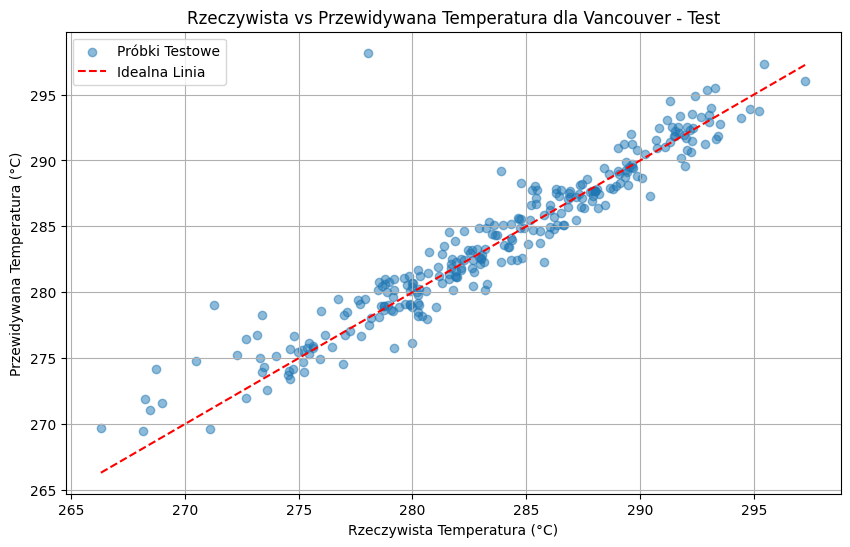

In [ ]:
# Scatter Plot Rzeczywista vs Przewidywana Temperatura
plt.figure(figsize=(10,6))
plt.scatter(y_temp_test_np, outputs_temp_test_np, alpha=0.5, label='Próbki Testowe')
plt.plot([y_temp_test_np.min(), y_temp_test_np.max()], [y_temp_test_np.min(), y_temp_test_np.max()], 'r--', label='Idealna Linia')
plt.xlabel('Rzeczywista Temperatura (°C)')
plt.ylabel('Przewidywana Temperatura (°C)')
plt.title('Rzeczywista vs Przewidywana Temperatura dla Vancouver - Test')
plt.legend()
plt.grid(True)
plt.show()

2. **Wykres Temperatura w Czasie**

Porównujemy rzeczywiste i przewidywane temperatury w kolejności próbek testowych, aby zobaczyć trend i zgodność modelu z rzeczywistością.


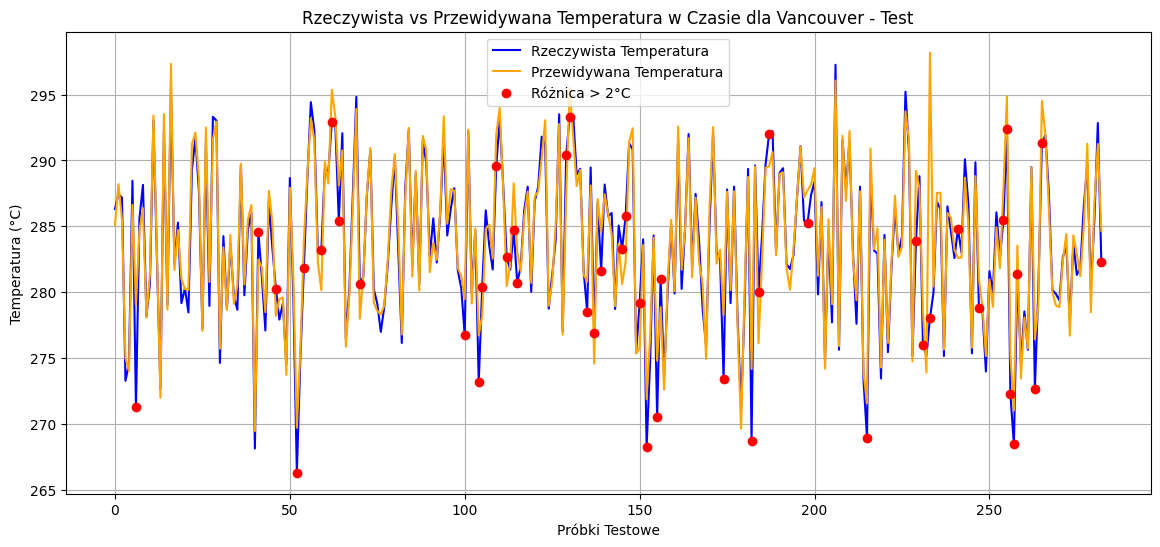

In [ ]:
# Wykres Temperatura w Czasie z zaznaczeniem różnic >2°C
plt.figure(figsize=(14,6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnicy i zaznaczenie punktów z wysokoą różnicą
differences = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title('Rzeczywista vs Przewidywana Temperatura w Czasie dla Vancouver - Test')
plt.legend()
plt.grid(True)
plt.show()

##### B. Wizualizacja dla Klasyfikacji Wiatru

1. **Macierz Konfuzji**

Tworzymy macierz konfuzji, aby zobaczyć, ile razy model prawidłowo klasyfikował silny i słaby wiatr oraz ile błędnie.


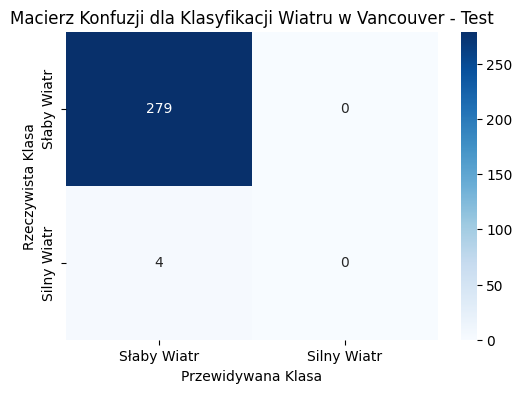

In [ ]:
# Macierz Konfuzji
cm = confusion_matrix(y_wind_test_np, y_wind_pred_np)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Słaby Wiatr', 'Silny Wiatr'], yticklabels=['Słaby Wiatr', 'Silny Wiatr'])
plt.xlabel('Przewidywana Klasa')
plt.ylabel('Rzeczywista Klasa')
plt.title('Macierz Konfuzji dla Klasyfikacji Wiatru w Vancouver - Test')
plt.show()

2. **Raport Klasyfikacji**

Wyświetlamy raport klasyfikacji, który zawiera precyzję, czułość, F1-score oraz inne metryki dla każdej klasy.


In [ ]:
# Raport Klasyfikacji
print("Raport Klasyfikacji dla Wiatru w Vancouver - Test:")
print(classification_report(y_wind_test_np, y_wind_pred_np, target_names=['Słaby Wiatr', 'Silny Wiatr']))

Raport Klasyfikacji dla Wiatru w Vancouver - Test:
              precision    recall  f1-score   support

 Słaby Wiatr       0.99      1.00      0.99       279
 Silny Wiatr       0.00      0.00      0.00         4

    accuracy                           0.99       283
   macro avg       0.49      0.50      0.50       283
weighted avg       0.97      0.99      0.98       283



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3. **Krzywa ROC i AUC**

Tworzymy krzywą ROC oraz obliczamy AUC, aby ocenić zdolność modelu do rozróżnienia między klasami w różnych progach decyzyjnych.


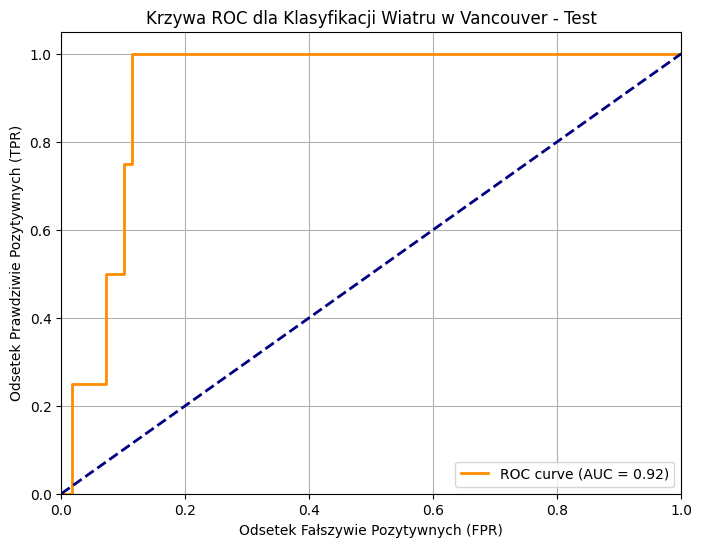

In [ ]:
# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_wind_test_np, outputs_wind_test_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (TPR)')
plt.title('Krzywa ROC dla Klasyfikacji Wiatru w Vancouver - Test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 4.2. Trenowanie Modelu dla Eilat

Trenujemy model dla wybranego miasta (Eilat).


In [ ]:
# Trenowanie modelu dla Eilat
city = 'Eilat'
model = WeatherModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()
criterion_wind = nn.BCELoss()  # Używamy BCELoss z sigmoid w modelu

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Trenowanie modelu
history = train_model(
    model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer,
    num_epochs=5000
)

Epoch [10/5000], Loss: 86675.9531, Val Loss: 86201.7109
Epoch [20/5000], Loss: 84219.6484, Val Loss: 83521.6250
Epoch [30/5000], Loss: 79766.2891, Val Loss: 78721.6016
Epoch [40/5000], Loss: 72684.1797, Val Loss: 71214.4062
Epoch [50/5000], Loss: 62879.7461, Val Loss: 60999.0430
Epoch [60/5000], Loss: 51030.9102, Val Loss: 48862.7266
Epoch [70/5000], Loss: 38634.5820, Val Loss: 36398.7578
Epoch [80/5000], Loss: 27673.3633, Val Loss: 25610.0020
Epoch [90/5000], Loss: 19840.7715, Val Loss: 18087.8828
Epoch [100/5000], Loss: 15592.8984, Val Loss: 14096.3604
Epoch [110/5000], Loss: 13823.2217, Val Loss: 12422.0195
Epoch [120/5000], Loss: 12924.8770, Val Loss: 11543.6104
Epoch [130/5000], Loss: 12065.3711, Val Loss: 10753.8379
Epoch [140/5000], Loss: 11155.9932, Val Loss: 9967.5508
Epoch [150/5000], Loss: 10263.6631, Val Loss: 9202.8105
Epoch [160/5000], Loss: 9400.2871, Val Loss: 8456.4189
Epoch [170/5000], Loss: 8559.5439, Val Loss: 7717.5342
Epoch [180/5000], Loss: 7741.9336, Val Loss: 6

#### Generowanie wizualizacji Modelu dla Eilat

Generujemy różne wizualizacje, aby ocenić wydajność modelu na danych testowych dla miasta Eilat.

In [ ]:
# Wizualizacje dla Eilat
city = 'Eilat'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz model w tryb ewaluacji
model.eval()
with torch.no_grad():
    outputs_temp_test, outputs_wind_test = model(X_test_tensor)

# Konwersja na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

##### A. Wizualizacja dla Temperatury

1. **Scatter Plot Rzeczywista vs Przewidywana Temperatura**

Tworzymy wykres punktowy porównujący rzeczywiste wartości temperatury z przewidywanymi przez model.


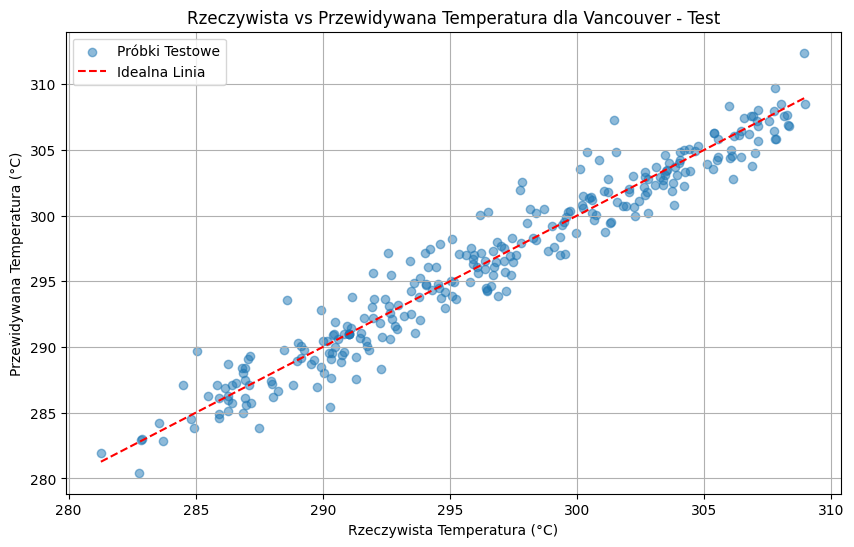

In [ ]:
# Scatter Plot Rzeczywista vs Przewidywana Temperatura
plt.figure(figsize=(10,6))
plt.scatter(y_temp_test_np, outputs_temp_test_np, alpha=0.5, label='Próbki Testowe')
plt.plot([y_temp_test_np.min(), y_temp_test_np.max()], [y_temp_test_np.min(), y_temp_test_np.max()], 'r--', label='Idealna Linia')
plt.xlabel('Rzeczywista Temperatura (°C)')
plt.ylabel('Przewidywana Temperatura (°C)')
plt.title('Rzeczywista vs Przewidywana Temperatura dla Eilat - Test')
plt.legend()
plt.grid(True)
plt.show()

2. **Wykres Temperatura w Czasie**

Porównujemy rzeczywiste i przewidywane temperatury w kolejności próbek testowych, aby zobaczyć trend i zgodność modelu z rzeczywistością.


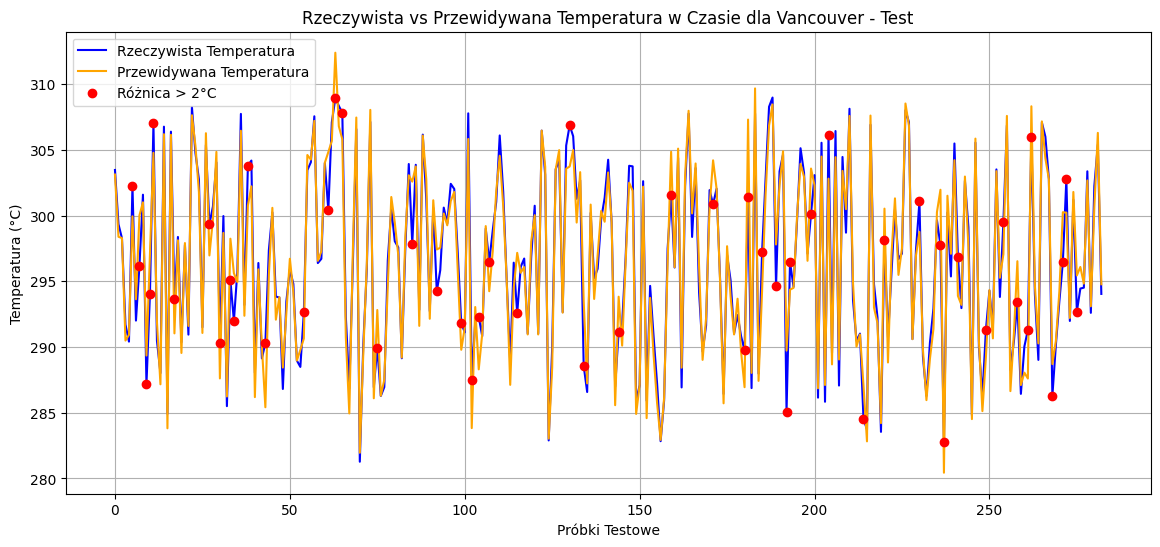

In [ ]:
# Wykres Temperatura w Czasie z zaznaczeniem różnic >2°C
plt.figure(figsize=(14,6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnicy i zaznaczenie punktów z wysokoą różnicą
differences = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title('Rzeczywista vs Przewidywana Temperatura w Czasie dla Eilat - Test')
plt.legend()
plt.grid(True)
plt.show()

##### B. Wizualizacja dla Klasyfikacji Wiatru

1. **Macierz Konfuzji**

Tworzymy macierz konfuzji, aby zobaczyć, ile razy model prawidłowo klasyfikował silny i słaby wiatr oraz ile błędnie.


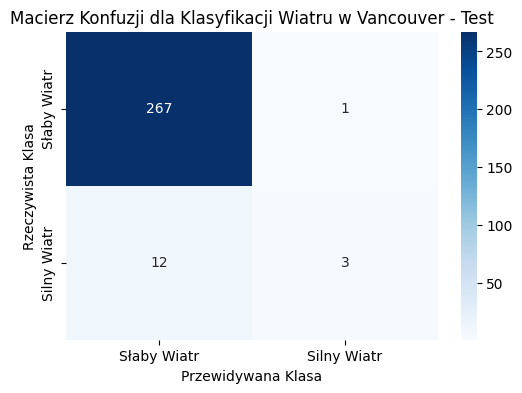

In [ ]:
# Macierz Konfuzji
cm = confusion_matrix(y_wind_test_np, y_wind_pred_np)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Słaby Wiatr', 'Silny Wiatr'], yticklabels=['Słaby Wiatr', 'Silny Wiatr'])
plt.xlabel('Przewidywana Klasa')
plt.ylabel('Rzeczywista Klasa')
plt.title('Macierz Konfuzji dla Klasyfikacji Wiatru w Eilat - Test')
plt.show()

2. **Raport Klasyfikacji**

Wyświetlamy raport klasyfikacji, który zawiera precyzję, czułość, F1-score oraz inne metryki dla każdej klasy.


In [ ]:
# Raport Klasyfikacji
print("Raport Klasyfikacji dla Wiatru w Eilat - Test:")
print(classification_report(y_wind_test_np, y_wind_pred_np, target_names=['Słaby Wiatr', 'Silny Wiatr']))

Raport Klasyfikacji dla Wiatru w Eilat - Test:
              precision    recall  f1-score   support

 Słaby Wiatr       0.96      1.00      0.98       268
 Silny Wiatr       0.75      0.20      0.32        15

    accuracy                           0.95       283
   macro avg       0.85      0.60      0.65       283
weighted avg       0.95      0.95      0.94       283



3. **Krzywa ROC i AUC**

Tworzymy krzywą ROC oraz obliczamy AUC, aby ocenić zdolność modelu do rozróżnienia między klasami w różnych progach decyzyjnych.


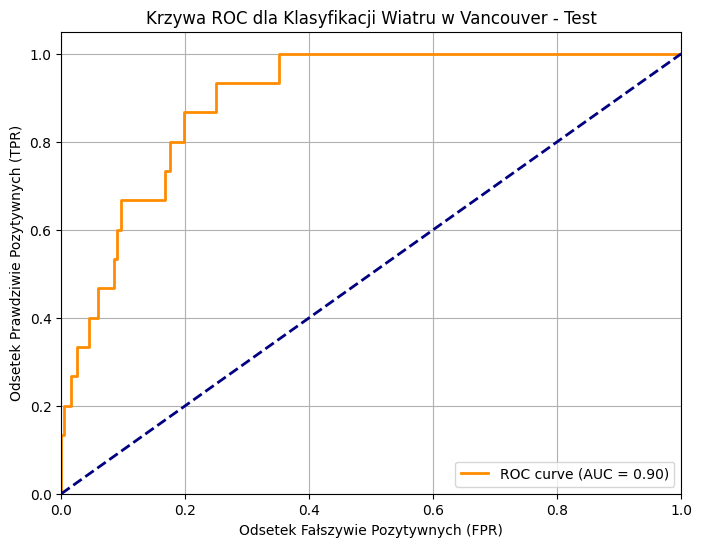

In [ ]:
# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_wind_test_np, outputs_wind_test_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (TPR)')
plt.title('Krzywa ROC dla Klasyfikacji Wiatru w Eilat - Test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 4.3. Trenowanie Modelu dla New York

Trenujemy model dla wybranego miasta (New York).


In [ ]:
# Trenowanie modelu dla New York
city = 'New York'
model = WeatherModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()
criterion_wind = nn.BCELoss()  # Używamy BCELoss z sigmoid w modelu

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trenowanie modelu
history = train_model(
    model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer,
    num_epochs=5000
)

Epoch [10/5000], Loss: 81383.3594, Val Loss: 81730.5312
Epoch [20/5000], Loss: 81254.3672, Val Loss: 81603.9609
Epoch [30/5000], Loss: 81119.8906, Val Loss: 81471.7109
Epoch [40/5000], Loss: 80976.6094, Val Loss: 81330.6016
Epoch [50/5000], Loss: 80821.2891, Val Loss: 81177.5625
Epoch [60/5000], Loss: 80650.7578, Val Loss: 81009.5234
Epoch [70/5000], Loss: 80462.2422, Val Loss: 80823.4062
Epoch [80/5000], Loss: 80253.0859, Val Loss: 80616.6875
Epoch [90/5000], Loss: 80020.8672, Val Loss: 80386.9844
Epoch [100/5000], Loss: 79763.3281, Val Loss: 80131.9219
Epoch [110/5000], Loss: 79478.4688, Val Loss: 79849.6484
Epoch [120/5000], Loss: 79164.6172, Val Loss: 79538.4922
Epoch [130/5000], Loss: 78820.0234, Val Loss: 79196.6797
Epoch [140/5000], Loss: 78443.5234, Val Loss: 78822.9375
Epoch [150/5000], Loss: 78033.8672, Val Loss: 78416.1172
Epoch [160/5000], Loss: 77590.2969, Val Loss: 77975.2812
Epoch [170/5000], Loss: 77111.9453, Val Loss: 77499.6641
Epoch [180/5000], Loss: 76598.3359, Val 

#### Generowanie wizualizacji Modelu dla New York

Generujemy różne wizualizacje, aby ocenić wydajność modelu na danych testowych dla miasta New York.

In [ ]:
# Wizualizacje dla New York
city = 'New York'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz model w tryb ewaluacji
model.eval()
with torch.no_grad():
    outputs_temp_test, outputs_wind_test = model(X_test_tensor)

# Konwersja na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

##### A. Wizualizacja dla Temperatury

1. **Scatter Plot Rzeczywista vs Przewidywana Temperatura**

Tworzymy wykres punktowy porównujący rzeczywiste wartości temperatury z przewidywanymi przez model.


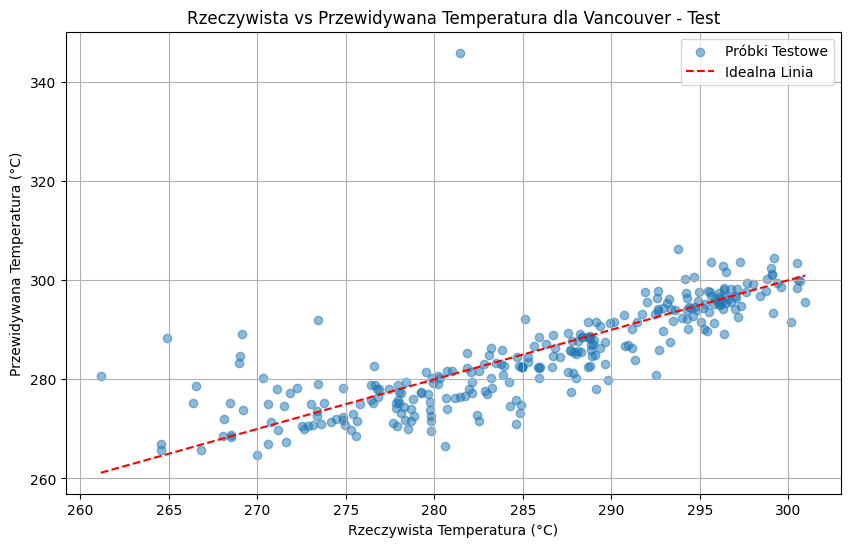

In [ ]:
# Scatter Plot Rzeczywista vs Przewidywana Temperatura
plt.figure(figsize=(10,6))
plt.scatter(y_temp_test_np, outputs_temp_test_np, alpha=0.5, label='Próbki Testowe')
plt.plot([y_temp_test_np.min(), y_temp_test_np.max()], [y_temp_test_np.min(), y_temp_test_np.max()], 'r--', label='Idealna Linia')
plt.xlabel('Rzeczywista Temperatura (°C)')
plt.ylabel('Przewidywana Temperatura (°C)')
plt.title('Rzeczywista vs Przewidywana Temperatura dla New York - Test')
plt.legend()
plt.grid(True)
plt.show()

2. **Wykres Temperatura w Czasie**

Porównujemy rzeczywiste i przewidywane temperatury w kolejności próbek testowych, aby zobaczyć trend i zgodność modelu z rzeczywistością.


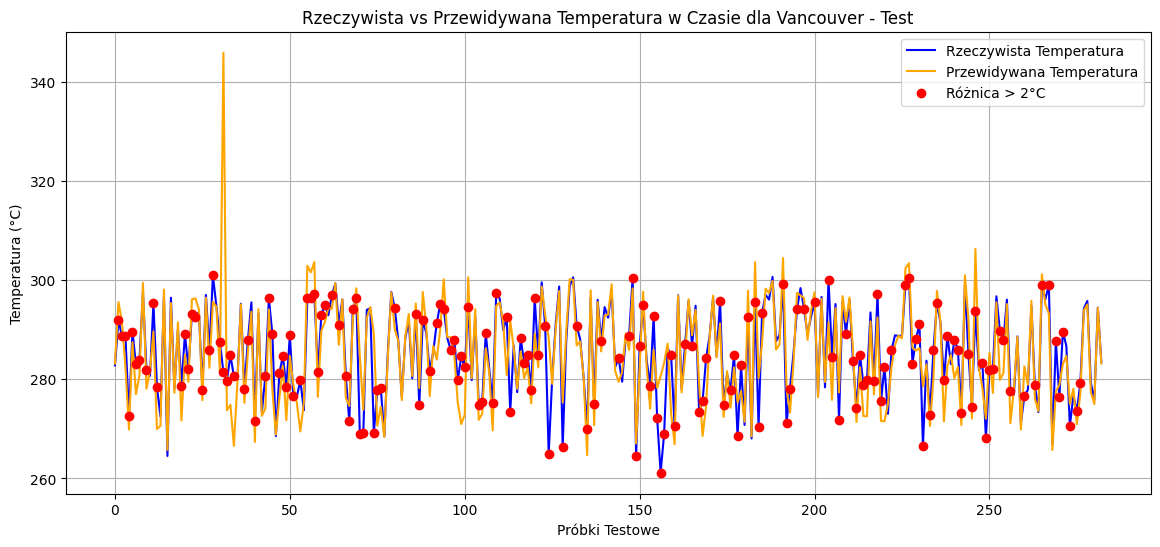

In [ ]:
# Wykres Temperatura w Czasie z zaznaczeniem różnic >2°C
plt.figure(figsize=(14,6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnicy i zaznaczenie punktów z wysokoą różnicą
differences = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title('Rzeczywista vs Przewidywana Temperatura w Czasie dla New York - Test')
plt.legend()
plt.grid(True)
plt.show()

##### B. Wizualizacja dla Klasyfikacji Wiatru

1. **Macierz Konfuzji**

Tworzymy macierz konfuzji, aby zobaczyć, ile razy model prawidłowo klasyfikował silny i słaby wiatr oraz ile błędnie.


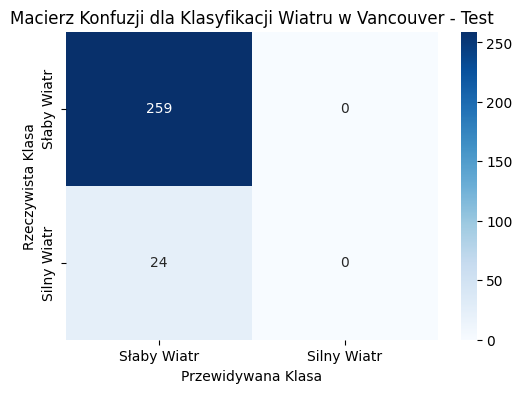

In [ ]:
# Macierz Konfuzji
cm = confusion_matrix(y_wind_test_np, y_wind_pred_np)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Słaby Wiatr', 'Silny Wiatr'], yticklabels=['Słaby Wiatr', 'Silny Wiatr'])
plt.xlabel('Przewidywana Klasa')
plt.ylabel('Rzeczywista Klasa')
plt.title('Macierz Konfuzji dla Klasyfikacji Wiatru w New York - Test')
plt.show()

2. **Raport Klasyfikacji**

Wyświetlamy raport klasyfikacji, który zawiera precyzję, czułość, F1-score oraz inne metryki dla każdej klasy.


In [ ]:
# Raport Klasyfikacji
print("Raport Klasyfikacji dla Wiatru w New York - Test:")
print(classification_report(y_wind_test_np, y_wind_pred_np, target_names=['Słaby Wiatr', 'Silny Wiatr']))

Raport Klasyfikacji dla Wiatru w New York - Test:
              precision    recall  f1-score   support

 Słaby Wiatr       0.92      1.00      0.96       259
 Silny Wiatr       0.00      0.00      0.00        24

    accuracy                           0.92       283
   macro avg       0.46      0.50      0.48       283
weighted avg       0.84      0.92      0.87       283



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3. **Krzywa ROC i AUC**

Tworzymy krzywą ROC oraz obliczamy AUC, aby ocenić zdolność modelu do rozróżnienia między klasami w różnych progach decyzyjnych.


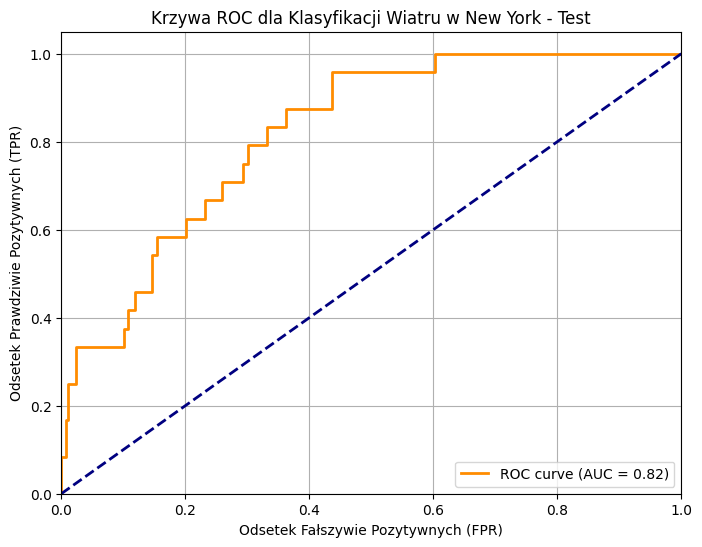

In [ ]:
# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_wind_test_np, outputs_wind_test_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (TPR)')
plt.title('Krzywa ROC dla Klasyfikacji Wiatru w New York - Test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()